<a href="https://colab.research.google.com/github/RenanAbbade/Python-for-Data-Science/blob/master/freqTwitterWordCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade google-api-python-client

     |████████████████████████████████| 7.1MB 6.8MB/s 
ERROR: google-drive 0.3.2 has requirement google-api-python-client==1.8.0, but you'll have google-api-python-client 2.5.0 which is incompatible.
ERROR: google-drive 0.3.2 has requirement google-auth-httplib2==0.0.3, but you'll have google-auth-httplib2 0.1.0 which is incompatible.
ERROR: earthengine-api 0.1.266 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 2.5.0 which is incompatible.
ERROR: drive 0.3.1 has requirement google-api-python-client==1.12.8, but you'll have google-api-python-client 2.5.0 which is incompatible.
  Found existing installation: google-auth-httplib2 0.0.3
    Uninstalling google-auth-httplib2-0.0.3:
      Successfully uninstalled google-auth-httplib2-0.0.3
  Found existing installation: google-api-python-client 1.8.0
    Uninstalling google-api-python-client-1.8.0:
      Successfully uninstalled google-api-python-client-1.8.0


**1º passo:** Instalação a biblioteca do google, para realização de consultas de arquivos do google drive

In [2]:
import re #importa expressões regulares
import nltk #lib de processamento de linguagem natural
import string
from google.colab import drive
import seaborn as sns
import spacy as sp
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import random

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.5.0'

In [4]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [5]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Solicitando permissão do drive para acessar os arquivos.


In [6]:
cols = ['tweet_id', 'author_id', 'inbound', 'created_at', 'text', 'response_tweet_id','in_response_to_tweet_id']

Registrando as colunas da tabela

In [7]:
train_data = pd.read_csv('/content/drive/MyDrive/IA/twitterSupport.csv', header = None,
                         names = cols, engine = 'python', encoding = 'latin1')

In [8]:
# Drop first row
train_data.drop(index=train_data.index[0], 
        axis=0, 
        inplace=True)

Retirando a primeira linha da tabela, referente aos rótulos que vieram do kraggle

In [9]:
train_data.shape

(93, 7)

In [10]:
train_data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,119237,105834,True,Wed Oct 11 06:55:44 +0000 2017,@AppleSupport causing the reply to be disregar...,119236,NaN
2,119238,ChaseSupport,False,Wed Oct 11 13:25:49 +0000 2017,@105835 Your business means a lot to us. Pleas...,NaN,119239
3,119239,105835,True,Wed Oct 11 13:00:09 +0000 2017,@76328 I really hope you all change but I'm su...,119238,NaN
4,119240,VirginTrains,False,Tue Oct 10 15:16:08 +0000 2017,@105836 LiveChat is online at the moment - htt...,119241,119242
5,119241,105836,True,Tue Oct 10 15:17:21 +0000 2017,@VirginTrains see attached error message. I've...,119243,119240


In [11]:
train_data.tail()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
89,119330,105859,True,Wed Oct 11 13:50:42 +0000 2017,@105860 I wish Amazon had an option of where I...,119329,119331
90,119331,105860,True,Wed Oct 11 13:47:14 +0000 2017,They reschedule my shit for tomorrow https://t...,119330,NaN
91,119332,Tesco,False,Wed Oct 11 13:34:06 +0000 2017,"@105861 Hey Sara, sorry to hear of the issues ...",119333,119334
92,119333,105861,True,Wed Oct 11 14:05:18 +0000 2017,@Tesco bit of both - finding the layout cumber...,"119335,119336",119332
93,119335,Tesco,False,Wed Oct 11 15:38:07 +0000 2017,@105861 If that doesn't help please DM your fu...,NaN,119333


Analisando os tipos de batalha que houveram na série, e fazendo a contagem dos mesmos.

**Limpeza da base de dados**: O objetivo deste passo e retirar todos os campos da base de dados que não serão utilizados pela aplicação.

In [12]:
data = train_data

In [13]:
data.drop(['tweet_id', 'author_id', 'created_at', 'response_tweet_id','in_response_to_tweet_id'], axis = 1, inplace=True)

In [14]:
data.head()

,inbound,text
1,True,@AppleSupport causing the reply to be disregar...
2,False,@105835 Your business means a lot to us. Pleas...
3,True,@76328 I really hope you all change but I'm su...
4,False,@105836 LiveChat is online at the moment - htt...
5,True,@VirginTrains see attached error message. I've...


Crindo uma variável para armazenar somente os textos.

In [20]:
X = data.iloc[:,1].values

In [72]:
X.shape

(93,)

In [73]:
type(X)

numpy.ndarray

In [16]:
from sklearn.model_selection import train_test_split

**Limpando os tweets**: Excluindo todos os caracteres que não sejam referentes aos textos dos tweets por meio de expressões regulares.

In [17]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) #Excluindo nome dos usuários
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)#Retirando as URL's
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)#Retirando os números
  tweet = re.sub(r" +", ' ', tweet)#Apagar os espaços na String
  return tweet.strip()


In [18]:
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [21]:
text = clean_tweets(text)
text

'Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

**Remoção das stopwords**: Exclusão das palavras que não atribuem um significado real ao texto.

In [22]:
nlp = sp.load('en') #importação para a lib space, na lingua inglesa
nlp

In [23]:
stop_words = sp.lang.en.STOP_WORDS #Recebendo as stopwords inglesas

**Tokenização**

In [24]:
def clean_tweets2(tweet):
  tweet = tweet.lower() #Conversão necessária para processamento da lib Space
  document = nlp (tweet)

  words = []
  wordsForFreq = ''
  for token in document:
    if(token.text not in stop_words and token.text not in string.punctuation and len(token.text) > 3):
      words.append(token.text)
      #words = ' '.join(token.text)
      wordsForFreq  = ' '.join([str(element) for element in words])
  
  #Incluir palavras na lista desde que não sejam similares a lista previamente criada de stopwords e que não sejam pontuações.
  #words = [word for word in words if word not in stop_words and word not in string.punctuation and len(word) > 3]
  #Retornando como String
  #words = ' '.join([str(element) for element in words])
  return wordsForFreq

In [25]:
text2 = clean_tweets2(text)
text2

'awww bummer shoulda david carr'

**Aplicação das funções de limpeza criadas na base de dados**

In [40]:
text = []
for tweet in X:
    text.append(clean_tweets2(clean_tweets(tweet)))
text

['causing reply disregarded tapped notification keyboard opened',
 'business means code additional details concern',
 'hope change sure',
 'livechat online moment contact option leave message request',
 'attached error message tried leaving voicemail times past week',
 'tried device miriam',
 'tried laptop times past week today tried different browsers',
 'working miriam link help',
 'haven heard number directed phone dead live chat doesn work',
 'miriam team send email shortly',
 'help version find settings general reply',
 'suffering hope find solution',
 'apple concern latest slow iphone happy solution',
 'thanks reaching happy help send look',
 'updated phone suddenly takes ages load update hate',
 'device happening know android spotify versions great',
 'thanks version armv anker bluetooth speaker samsung galaxy model distance speaker matter',
 'thanks distance possibly affect playback logging restarting device logging difference',
 'moved speaker metre away skipping metres away f

In [41]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
"""
Desc: 
 Function to convert List of strings to a string with a separator
"""
def converttostr(text, separator):
   # Join all the strings in list
   final_str = seperator.join(text)
   return final_str



# List of month names separated with a space
seperator = ' '
newText =  converttostr(text, seperator)
newText

'causing reply disregarded tapped notification keyboard opened business means code additional details concern hope change sure livechat online moment contact option leave message request attached error message tried leaving voicemail times past week tried device miriam tried laptop times past week today tried different browsers working miriam link help haven heard number directed phone dead live chat doesn work miriam team send email shortly help version find settings general reply suffering hope find solution apple concern latest slow iphone happy solution thanks reaching happy help send look updated phone suddenly takes ages load update hate device happening know android spotify versions great thanks version armv anker bluetooth speaker samsung galaxy model distance speaker matter thanks distance possibly affect playback logging restarting device logging difference moved speaker metre away skipping metres away fingers crossed great hear comes know carry helping brilliant thanks welco

In [44]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [55]:
sentencas = sent_tokenize(newText)  # Separa em linhas
palavras = word_tokenize(newText.lower())  # Separa em palavras

In [46]:
from nltk.probability import FreqDist

In [64]:
frequencia = FreqDist(palavras)


In [63]:
for item in sorted(frequencia, key = frequencia.get, reverse=True):
    print( item, frequencia[item])

help 19
thanks 13
phone 9
version 8
device 7
look 7
update 7
tried 6
send 6
happy 6
know 6
apps 5
sorry 5
battery 5
reply 4
email 4
apple 4
iphone 4
spotify 4
speaker 4
logging 4
time 4
like 4
store 4
hope 3
times 3
miriam 3
today 3
working 3
number 3
find 3
latest 3
reaching 3
updated 3
happening 3
hear 3
love 3
experiencing 3
delay 3
life 3
running 3
weeks 3
account 3
service 3
music 3
problem 3
issues 3
issue 3
address 3
thomas 3
cache 3
cookies 3
means 2
code 2
concern 2
sure 2
moment 2
option 2
message 2
past 2
week 2
link 2
haven 2
doesn 2
solution 2
load 2
android 2
great 2
bluetooth 2
model 2
distance 2
matter 2
playback 2
restarting 2
difference 2
away 2
skipping 2
songs 2
steps 2
broken 2
frequently 2
flight 2
long 2
airways 2
provide 2
fucking 2
minutes 2
plus 2
start 2
getting 2
understand 2
experience 2
hours 2
assistance 2
sprint 2
happens 2
listen 2
whatsapp 2
kind 2
having 2
exact 2
points 2
immediately 2
answer 2
depart 2
called 2
person 2
buying 2
colleagues 2
think 2

In [65]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [68]:
# gerar uma wordcloud
wordcloud = WordCloud(background_color="black",
                      width=1600, height=800).generate(newText)

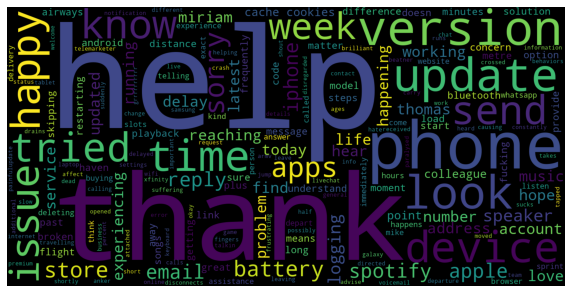

In [69]:
# mostrar a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
 
plt.imshow(wordcloud);